In [1]:
import wobble
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
o = 56
data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o])
results = wobble.Results(data)

In [5]:
'''for r in range(data.R):
    model = wobble.Model(data, results, r)

    model.add_star('star')
    model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)

    model.setup()

    model.optimize(niter=60)
'''

"for r in range(data.R):\n    model = wobble.Model(data, results, r)\n\n    model.add_star('star')\n    model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)\n\n    model.setup()\n\n    model.optimize(niter=60)\n"

In [4]:
validation_epochs = np.random.choice(data.N, data.N//10, replace=False)
training_epochs = np.delete(np.arange(data.N), validation_epochs)
    
training_data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o], mask_epochs=validation_epochs)
training_results = wobble.Results(training_data)

validation_data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o], mask_epochs=training_epochs)
validation_results = wobble.Results(validation_data)

In [5]:
r = 0
training_model = wobble.Model(training_data, training_results, r)
training_model.add_star('star')
training_model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)
training_model.setup()

validation_model = wobble.Model(validation_data, validation_results, r)
validation_model.add_star('star')
validation_model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)
validation_model.setup()

In [6]:
regularization_dict = {training_model.components[0].L1_template_tensor: 1.e1,
                      training_model.components[0].L2_template_tensor: 1.e3,
                      training_model.components[1].L1_template_tensor: 1.e3,
                      training_model.components[1].L2_template_tensor: 1.e6,
                      training_model.components[1].L1_basis_vectors_tensor: 1.e8,
                      training_model.components[1].L2_basis_vectors_tensor: 1.e0,
                      training_model.components[1].L2_basis_weights_tensor: 1.0,}

In [7]:
training_model.optimize(niter=60, feed_dict=regularization_dict)

100%|██████████| 60/60 [00:04<00:00, 14.85it/s]


In [8]:
validation_dict = {**regularization_dict}
for c in validation_model.components:
    validation_dict[getattr(c, 'template_xs')] = getattr(training_model.results, c.name+'_template_xs')[r]
    validation_dict[getattr(c, 'template_ys')] = getattr(training_model.results, c.name+'_template_ys')[r]

In [9]:
session = wobble.utils.get_session()
for i in tqdm(range(60)):
    session.run(validation_model.components[0].opt_rvs, feed_dict=validation_dict)
session.run(validation_model.nll)

100%|██████████| 60/60 [00:02<00:00, 21.74it/s]


319687.2985067851

In [10]:
for c in validation_model.components:
    validation_model.results.update(c)

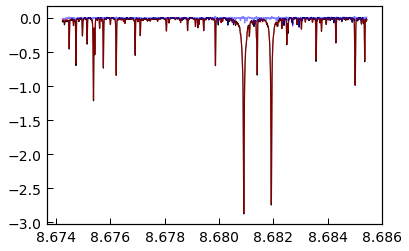

In [11]:
n = validation_epochs[0]
plt.plot(data.xs[r][n], data.ys[r][n], color='k')
plt.plot(data.xs[r][n], validation_results.star_ys_predicted[r][n], color='r', alpha=0.5)
plt.plot(data.xs[r][n], validation_results.tellurics_ys_predicted[r][n], color='b', alpha=0.5)
#plt.xlim([8.252, 8.255])

In [12]:
#results.write('results.hdf5')